In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import netCDF4
from scipy import stats
import statsmodels.api as sm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import sys
from mpl_toolkits.axes_grid1 import make_axes_locatable
sys.path.append('/Users/gbromley/Dropbox/code/python_utilities/')
from python_data_functions import extract_months
from python_met_functions import sat_vap_pres
from python_data_functions import mk_test
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText



/Users/gbromley/anaconda/envs/paper1_research/lib/python3.6/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [2]:
data_dir = '/Users/gbromley/Dropbox/CRUTS4.01/'
output_dir='/Users/gbromley/code/NGP_Climate/'
temp_file = 'cru_ts4.01.1901.2016.tmp.dat.nc'
#vap_file = 'vap/cru_ts3.24.1901.2015.vap.dat.nc'
#nc_vap = xr.open_dataset(data_dir+vap_file)
nc_temp = xr.open_dataset(data_dir+temp_file)


In [ ]:
nc_temp

In [3]:
t2m = nc_temp['tmp']


In [4]:
#t_season='AMJ'
#t_months=[4,5,6]
start_year = '1970-01-01'
end_year = '2016-01-01'
ext_e = -92
ext_w = -120
ext_n = 55
ext_s = 38
t2m = t2m.sel(lat=slice(ext_s-5,ext_n+5),lon=slice(ext_w-5,ext_e+5))
#ggw_lat,ggw_lon = 48.18, -106.635

In [5]:
#extract the time period we are interested in
t2m_slice=t2m.sel(time=slice(start_year,end_year))


#extract the 30 yr climate normal times
t2m_clim_30= t2m.sel(time=slice('1980-01-01','2011-01-01'))

#create averages over months for climate normal
t2m_clim_months_avg = t2m_clim_30.groupby('time.month').mean(dim='time')

/Users/gbromley/anaconda/envs/paper1_research/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [6]:
t2m_new = t2m_slice.groupby('time.month').apply(lambda x: x.groupby('time.year').mean(dim='time'))

In [7]:
anom = t2m_new - t2m_clim_months_avg

In [8]:
#create 2d structure to hold slope
month = ['January','February','March','April','May','June','July','August','September','October','November','December']
lat = t2m.lat
lon=t2m.lon
vals = np.empty(shape=(12,54,76))
vals[:,:,:] = np.nan
spatial_trend = xr.DataArray(vals,coords=[month,lat,lon],dims=['month','lat','lon'])
spatial_trend.name = 't2m_trend'
spatial_trend.attrs['units'] = 'C per Decade'
spatial_trend.attrs['long_name'] = '2 meter temperature trend'

#spatial_trend = xr.DataArray(np.random.rand(4,54,76),coords=[season,lat,lon],dims=['season','lat','lon'])


slope_scipy = t2m.isel(time=1).copy(deep=True)
#create 2d structure to hold pvalues
lat = t2m.lat
lon=t2m.lon
pvalues = xr.DataArray(np.random.rand(12,54,76),coords=[month,lat,lon],dims=['month','lat','lon'])
pvalues.name = 't2m_trend_pvalues'
pvalues.attrs['units'] = 'pvalues'
pvalues.attrs['long_name'] = '2 meter temperature trend pvalues'

In [9]:
#calculate slope and pvalue for each grid point
#replace with a map() call?
corr_vals = np.arange(0,len(anom.year))
corr_vals = sm.add_constant(corr_vals)
for k in np.arange(0,12):
    for i in np.arange(0,len(anom['lat'])):
        for j in np.arange(0,len(anom['lon'])):
            series = anom[k,i,j,:]
            model = sm.OLS(series.values,corr_vals)
            ac_coe = sm.tsa.stattools.acf(series.values)
            #model = sm.OLS(series.values,corr_vals)
            #slope_2, intercept_2, r_value_2, p_value_2, std_err_2 = stats.linregress(corr_vals,anom.values)
            results = model.fit()
            slope = results.params[1]
            adjusted_error = results.bse[1] * (np.sqrt((1-ac_coe[1])/(1+ac_coe[1])))
            t_value = ((slope)/adjusted_error)
            #tw0-sided
            p_value = 2*(1-stats.t.cdf(abs(t_value), results.df_resid))
            #t_value = ((slope - 0.02)/results.bse[1])
            #p_value = stats.t.cdf(t_value, results.df_resid)
            #p_value = stats.t.sf(results.tvalues[0], results.df_resid)
            spatial_trend[k,i,j]=slope*10
            #slope_scipy[i,j] = slope_2*10
            pvalues[k,i,j]= p_value

In [10]:
pvals = pvalues.where(pvalues.values < 0.05)

/Users/gbromley/anaconda/envs/paper1_research/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


In [ ]:
pvals[11,:,:]

In [ ]:
pvals.to_netcdf(data_dir+'pvals_temp_clim_season_2_27_18.nc')

In [ ]:
spatial_trend.to_dataset().to_netcdf(data_dir+'CRU_temp_tobias'+t_season+'_'+'1970'+'.nc')

In [ ]:
pvalues.to_dataset().to_netcdf(t_season+'_1970_pvalues.nc')

In [ ]:
#create figure
cb_min = -6
cb_max = 6
cols = ['#67001f','#b2182b','#d6604d','#f4a582','#fddbc7','#d1e5f0','#92c5de','#4393c3','#2166ac','#053061']
cus_cols = cols[::-1]
levs = [-.6,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.6]
#np.linspace(cb_min, cb_max, len(cus_col))
fig = plt.figure(1,figsize=(13,7), dpi=400.0)
#create projection
projection = ccrs.LambertConformal(central_longitude=-105,central_latitude=45,standard_parallels=[50,40])
ax1 = plt.subplot(2,2,1, projection = projection)

cb = plt.contourf(spatial_trend.lon,spatial_trend.lat,spatial_trend[0,:,:].values,transform=ccrs.PlateCarree(),levels=levs,cmap='RdBu_r', extend='both')
pvals[0,:,:].plot.contourf(axes=ax1,transform=ccrs.PlateCarree(),color='none',edgecolor='black',hatches=["..."],alpha=0.,add_colorbar = False)
ax1.set_extent([ext_e, ext_w, ext_s, ext_n])
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax1.add_feature(states_provinces, edgecolor='lightgray')
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS)
shape_feature = ShapelyFeature(Reader('/Users/gbromley/Dropbox/Montana_Climate_Project/Study_Area/Study_Area_08_01_17.shp').geometries(),crs=ccrs.PlateCarree(), facecolor='none',edgecolor='black')
ax1.add_feature(shape_feature)
ax1.title.set_text('DJF')
at = AnchoredText("a",
                  prop=dict(size=8), frameon=True,
                  loc=2,
                  #backgroundcolor = 'lightgray'
                  )
ax1.add_artist(at)

ax2 = plt.subplot(2,2,2, projection = projection)

plt.contourf(spatial_trend.lon,spatial_trend.lat,spatial_trend[2,:,:].values,transform=ccrs.PlateCarree(),levels=levs,cmap='RdBu_r', extend='both')
pvals[2,:,:].plot.contourf(axes=ax1,transform=ccrs.PlateCarree(),color='none',edgecolor='black',hatches=["..."],alpha=0.,add_colorbar = False)

ax2.set_extent([ext_e, ext_w, ext_s, ext_n])
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax2.add_feature(states_provinces, edgecolor='lightgray')
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS)
ax2.add_feature(shape_feature)
bt = AnchoredText("b",
                  prop=dict(size=8), frameon=True,
                  loc=2,
                  #backgroundcolor = 'lightgray'
                  )
ax2.add_artist(bt)
ax2.set_title('MAM')
#ax2.title.set_visible(False)

ax3 = plt.subplot(2,2,3, projection = projection)

plt.contourf(spatial_trend.lon,spatial_trend.lat,spatial_trend[1,:,:].values,transform=ccrs.PlateCarree(),levels=levs,cmap='RdBu_r', extend='both')
#ax = plt.axes(projection=ccrs.LambertConformal())
pvals[1,:,:].plot.contourf(axes=ax1,transform=ccrs.PlateCarree(),color='none',edgecolor='black',hatches=["..."],alpha=0.,add_colorbar = False)

ax3.set_extent([ext_e, ext_w, ext_s, ext_n])
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax3.add_feature(states_provinces, edgecolor='lightgray')
ax3.add_feature(cfeature.COASTLINE)
ax3.add_feature(cfeature.BORDERS)
ax3.add_feature(shape_feature)
ct = AnchoredText("c",
                  prop=dict(size=8), frameon=True,
                  loc=2,
                  #backgroundcolor = 'lightgray'
                  )
ax3.add_artist(ct)
ax3.set_title('JJA')

ax4 = plt.subplot(2,2,4, projection = projection)

plt.contourf(spatial_trend.lon,spatial_trend.lat,spatial_trend[4,:,:].values,transform=ccrs.PlateCarree(),levels=levs,cmap='RdBu_r', extend='both')
#ax = plt.axes(projection=ccrs.LambertConformal())
pvals[3,:,:].plot.contourf(axes=ax1,transform=ccrs.PlateCarree(),color='none',edgecolor='black',hatches=["..."],alpha=0.,add_colorbar = False)
ax4.set_extent([ext_e, ext_w, ext_s, ext_n])
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax4.add_feature(states_provinces, edgecolor='lightgray')
ax4.add_feature(cfeature.COASTLINE)
ax4.add_feature(cfeature.BORDERS)
ax4.add_feature(shape_feature)
dt = AnchoredText("d",
                  prop=dict(size=8), frameon=True,
                  loc=2,
                  #backgroundcolor = 'lightgray'
                  )
ax4.add_artist(dt)
ax4.set_title('SON')
fig.subplots_adjust(top=0.9,bottom=0.1,left=0.25,right=0.75,hspace=0.1,wspace=0.1)
fig.suptitle('Temperature Trends 1970-2015')
cax = fig.add_axes((0.76, 0.12, 0.03, 0.76))
col_bar = fig.colorbar(cb,cax=cax)
col_bar.set_label('$^\circ$C / Decade',fontsize=10)

#plt.tight_layout()
#plt.savefig('/Users/gbromley/Dropbox/Montana_Climate_Project/NGP_Climatology_Paper/Figures/four_panel_temp.png',bbox_inches='tight')
plt.show()


In [11]:
ngp_mask = xr.open_dataset('/Users/gbromley/Dropbox/Montana_Climate_Project/Study_Area/ngp_mask.nc')
ngp_mask = ngp_mask.rename({'__xarray_dataarray_variable__':'ngp'})

In [12]:
mask = ngp_mask['ngp']
ngp = spatial_trend.where(mask==1)
test = ngp.stack(z=('lat','lon'))

In [13]:
season_values = test.groupby('month').apply(lambda x: x.dropna(dim='z'))

Text(0, 0.5, 'Temperature Trend $^\\circ$C / Decade')

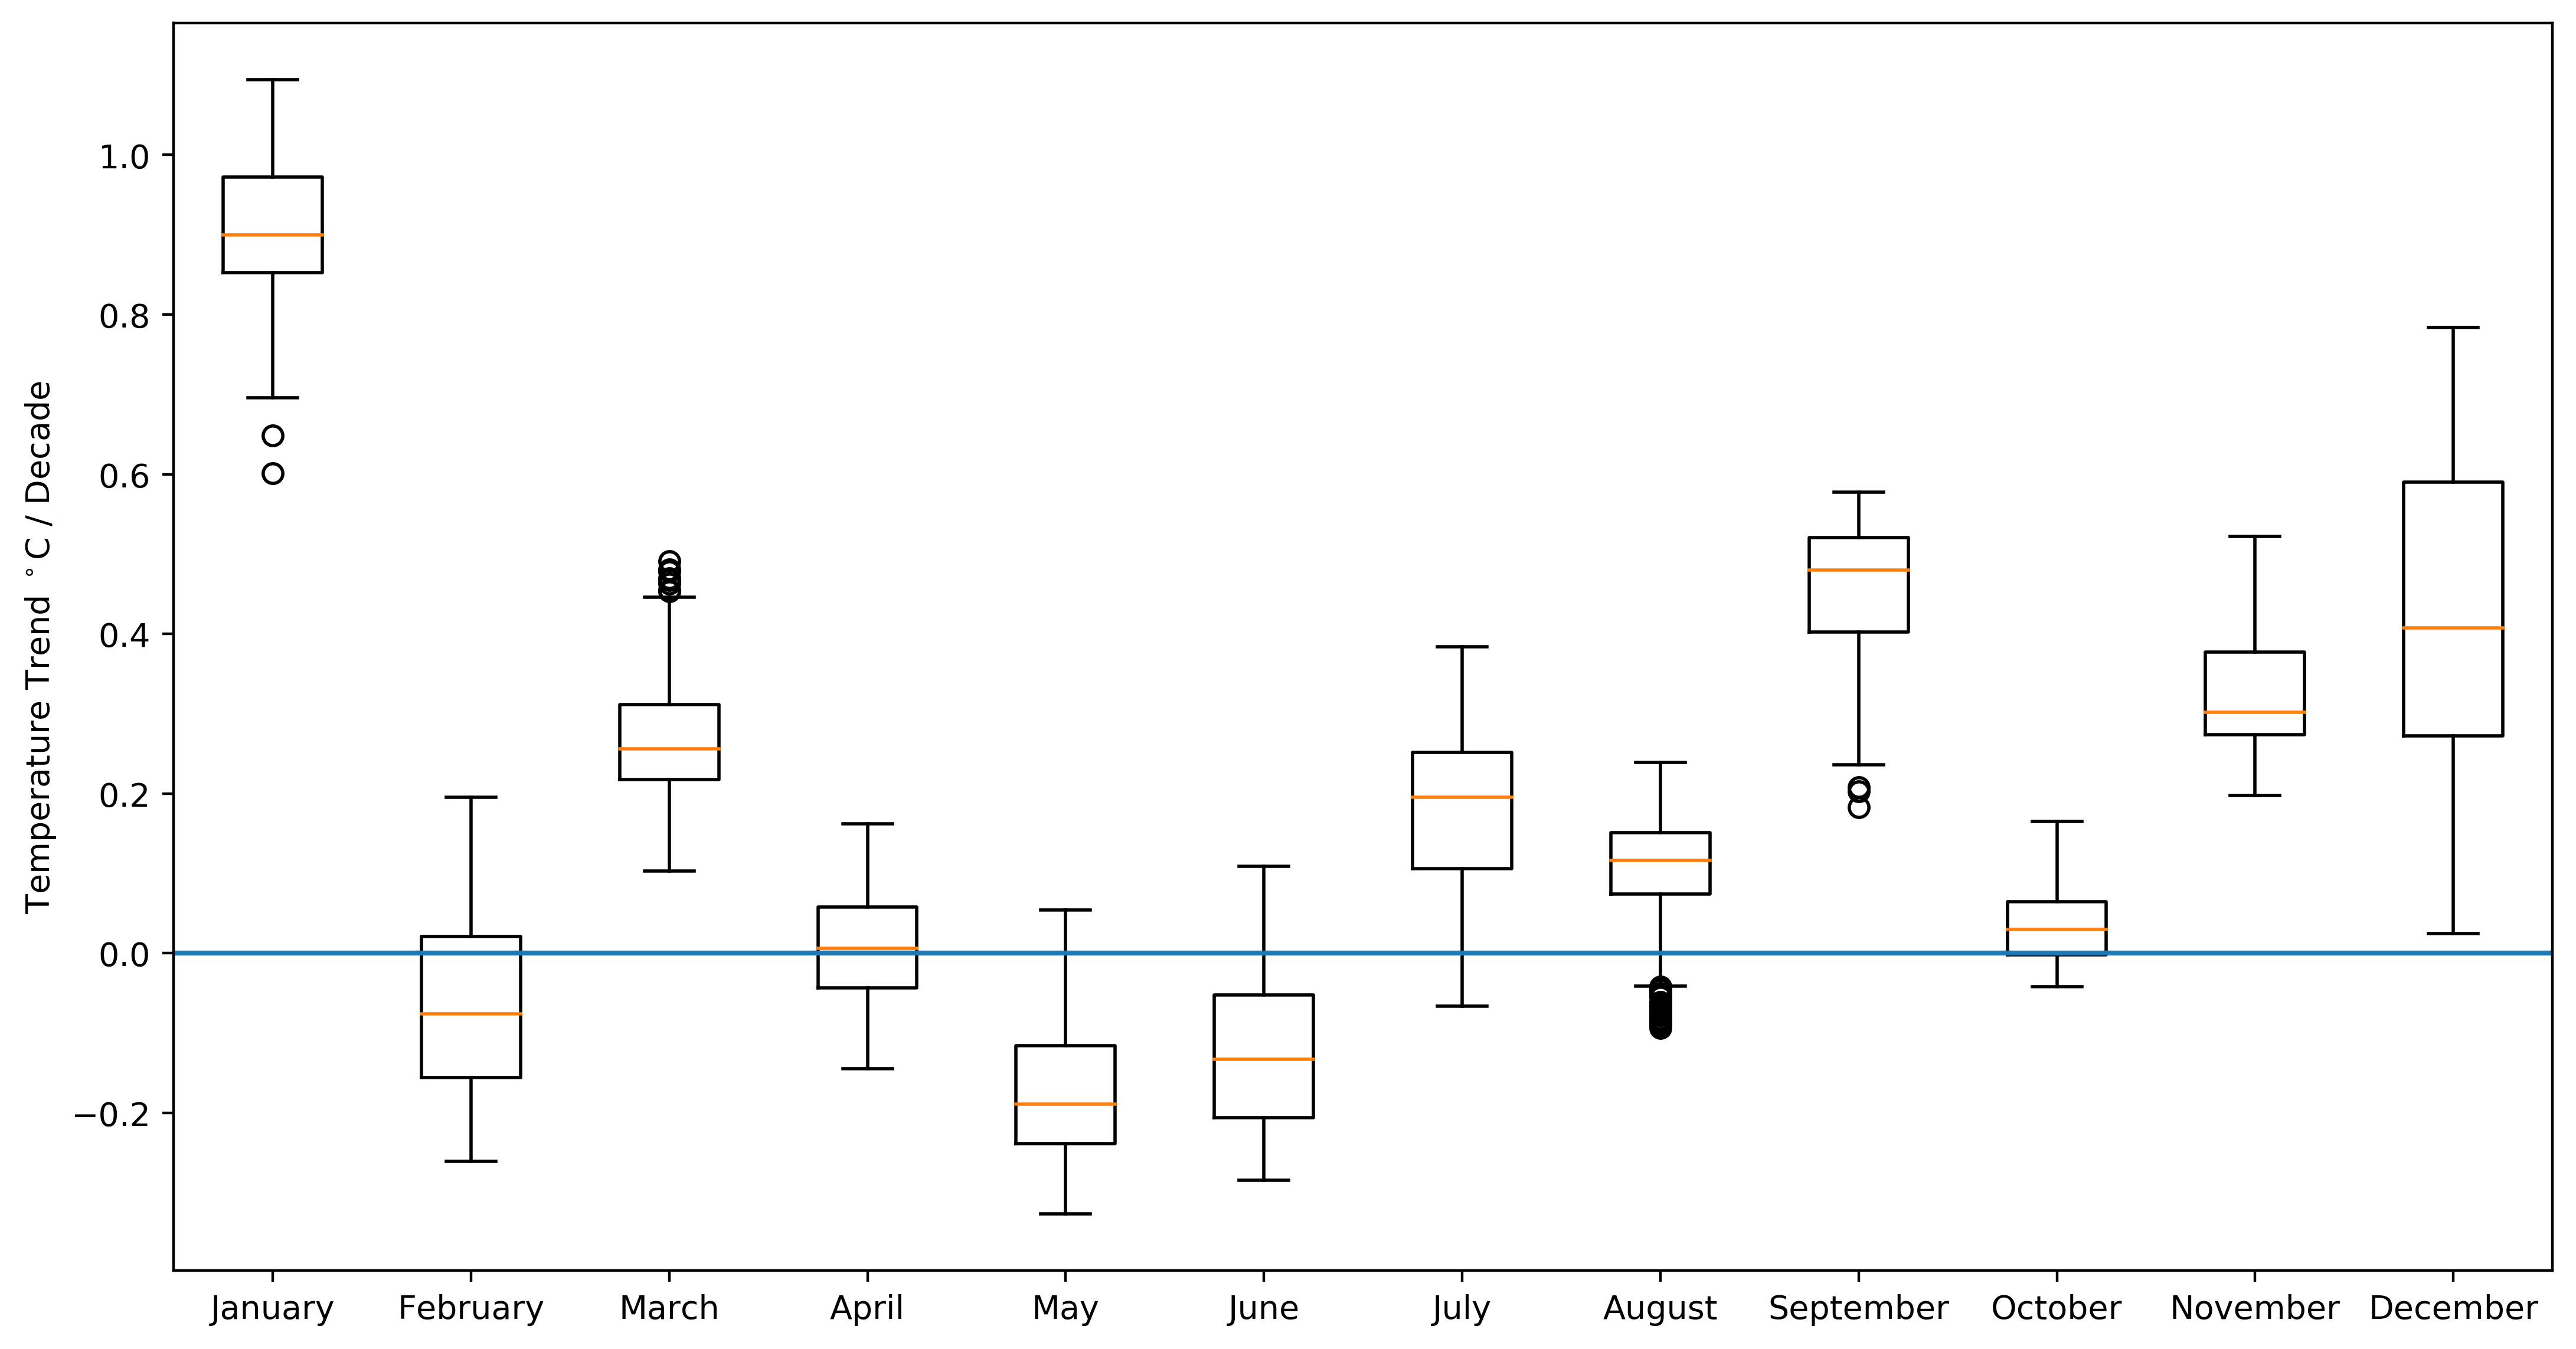

In [14]:
month = ['January','February','March','April','May','June','July','August','September','October','November','December']
fig, ax = plt.subplots(ncols=1)
fig.set_dpi(400)
fig.set_size_inches((13,7))
pos = np.array(range(len(season_values))) + 1
plt.boxplot(season_values, positions=pos)
plt.xticks([1, 2, 3,4,5,6,7,8,9,10,11,12], month)
ax.axhline(0)
ax.set_ylabel('Temperature Trend $^\circ$C / Decade')
#plt.savefig('/Users/gbromley/Dropbox/Montana_Climate_Project/NGP_Climatology_Paper/Figures/temp_trend_boxplots.png',bbox_inches='tight')


In [24]:

season_values.to_netcdf('/Users/gbromley/Dropbox/Montana_Climate_Project/EOS/NGP_Temp_monthly.nc')

In [19]:
season_values

<xarray.DataArray 't2m_trend' (month: 12, z: 636)>
array([[ 0.789208,  0.790996,  0.754425, ...,  1.049522,  1.023929,  1.039778],
       [-0.111255, -0.103053, -0.218933, ...,  0.123651,  0.179895,  0.192168],
       [ 0.49078 ,  0.431946,  0.469565, ...,  0.233488,  0.102683,  0.128153],
       ...,
       [ 0.066667,  0.04243 ,  0.057848, ..., -0.023558, -0.036509, -0.028554],
       [ 0.459698,  0.436756,  0.390194, ...,  0.311008,  0.272834,  0.282393],
       [ 0.113228,  0.159297,  0.04909 , ...,  0.678076,  0.613876,  0.628122]])
Coordinates:
  * z        (z) MultiIndex
  - lat      (z) float64 41.25 41.25 41.75 41.75 ... 42.25 42.25 42.25 42.25
  - lon      (z) float64 -101.8 -101.2 -104.8 -104.2 ... -100.8 -100.2 -99.75
  * month    (month) <U9 'January' 'February' 'March' ... 'November' 'December'
Attributes:
    units:      C per Decade
    long_name:  2 meter temperature trend

In [22]:
season_values = season_values.reset_index('z')

In [23]:
season_values.to_netcdf


<xarray.DataArray 't2m_trend' (month: 12, z: 636)>
array([[ 0.789208,  0.790996,  0.754425, ...,  1.049522,  1.023929,  1.039778],
       [-0.111255, -0.103053, -0.218933, ...,  0.123651,  0.179895,  0.192168],
       [ 0.49078 ,  0.431946,  0.469565, ...,  0.233488,  0.102683,  0.128153],
       ...,
       [ 0.066667,  0.04243 ,  0.057848, ..., -0.023558, -0.036509, -0.028554],
       [ 0.459698,  0.436756,  0.390194, ...,  0.311008,  0.272834,  0.282393],
       [ 0.113228,  0.159297,  0.04909 , ...,  0.678076,  0.613876,  0.628122]])
Coordinates:
  * month    (month) <U9 'January' 'February' 'March' ... 'November' 'December'
    lat      (z) float64 41.25 41.25 41.75 41.75 ... 53.25 53.25 53.75 53.75
    lon      (z) float64 -101.8 -101.2 -104.8 -104.2 ... -110.2 -114.2 -113.8
Dimensions without coordinates: z
Attributes:
    units:      C per Decade
    long_name:  2 meter temperature trend